In [1]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [23]:
!pip install geemap


In [2]:
import ee  # Earth Engine
import geemap  # Для работы с интерактивными картами
import datetime
from ipyleaflet import LayersControl

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='aquavision-satellite-photo')


In [3]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD12Q1! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1

  warnings.warn(warning, category=DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD11A1! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1

  warnings.warn(warning, category=DeprecationWarning)


In [4]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [5]:
# Определим город Актобе как точку интереса
u_lon = 57.17
u_lat = 50.28
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Определим точку в сельской местности недалеко от Актобе
r_lon = 57.5
r_lat = 50.5
r_poi = ee.Geometry.Point(r_lon, r_lat)


In [6]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 214 m
Average daytime LST at urban point: 22.95 °C
Land cover value at urban point is: 13


In [7]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', 57.173276257786945, 50.28319802859022, 1483228800000, None, 2],
 ['2017_01_02', 57.173276257786945, 50.28319802859022, 1483315200000, None, 2],
 ['2017_01_03', 57.173276257786945, 50.28319802859022, 1483401600000, None, 2],
 ['2017_01_04', 57.173276257786945, 50.28319802859022, 1483488000000, None, 2]]

In [8]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [9]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
13,1484352000000,2017-01-14,-15.25
14,1484438400000,2017-01-15,-14.99
15,1484524800000,2017-01-16,-11.07
16,1484611200000,2017-01-17,-12.57
17,1484697600000,2017-01-18,-14.43


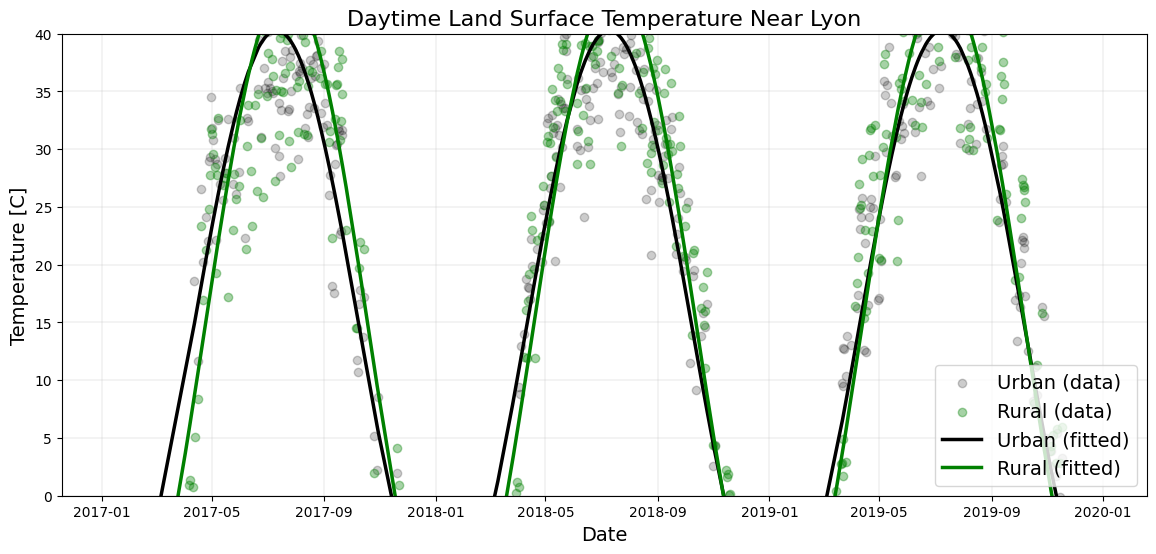

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [11]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(1e6)

In [12]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)


In [13]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/aquavision-satellite-photo/thumbnails/8815900d4dfe6a0d2f29960a41ed29ae-2e7dd3ecc4e1f2c25c0aa8b546b27cbe:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [14]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

# Create a buffer zone of 10 km around Lyon.
lyon = u_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': lyon, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

In [15]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'Kazakhstan'))

# Clip the image by France.
elv_fr = elv_img.clip(france)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in Kazakhstan.
Image(url=url)

In [16]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_near_aktobe_kz',
                                     scale=30,
                                     region=lyon,
                                     fileNamePrefix='my_export_lyon',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [17]:
task.status()

{'state': 'READY',
 'description': 'elevation_near_aktobe_kz',
 'priority': 100,
 'creation_timestamp_ms': 1730185020676,
 'update_timestamp_ms': 1730185020676,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': '6AWD755KIZTM2UO2TCMDFFQL',
 'name': 'projects/aquavision-satellite-photo/operations/6AWD755KIZTM2UO2TCMDFFQL'}

In [18]:
link = lst_img.getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': lyon})
print(link)

https://earthengine.googleapis.com/v1/projects/aquavision-satellite-photo/thumbnails/a4eb21b7ba4521f96af3ec9a13fb6ffd-2935077d9892687bd54a2ecda94921ce:getPixels


In [19]:
import folium

# Определим центр карты для Актобе
lat, lon = 50.28, 57.17

# Создаем карту, центрированную на Актобе
my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map


In [28]:
selected_year_1 = 2017

In [20]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [21]:
!pip install geopy


In [22]:
import folium
from geopy.geocoders import Nominatim
import random

# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,
    'max': 17,
    'palette': ['05450a', '086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Define the coordinates for Aktobe
lat, lon = 50.28, 57.17

# Create a map with the OpenStreetMap base layer
my_map = folium.Map(location=[lat, lon], zoom_start=12, tiles='OpenStreetMap')

# Add a marker for Aktobe
folium.Marker(
    location=[lat, lon],
    popup="Актобе",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(my_map)

geolocator = Nominatim(user_agent="my_map")

# Function to get address details
def get_address(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.raw['address']
    else:
        return None

# Add additional base layers for more options
folium.TileLayer('Stamen Terrain', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Toner', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Watercolor', attr='Stamen Design').add_to(my_map)
folium.TileLayer('CartoDB positron', attr='CartoDB').add_to(my_map)
folium.TileLayer('CartoDB dark_matter', attr='CartoDB').add_to(my_map)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(ee_image, vis_params, name):
    # Convert the Earth Engine image to a URL
    url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format
    folium.raster_layers.TileLayer(
        tiles=url,
        attr="Google",
        overlay=True,
        name=name,
        control=True,
        opacity=0.5  # Set opacity to allow base map visibility
    ).add_to(my_map)

# Add land cover layer with the specified visualization parameters
add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add layer control to the map
my_map.add_child(folium.LayerControl())

# Display the map
my_map


In [23]:
# Select a specific year for the land cover
selected_year = 2020  # Change this to your desired year

# Define the start and end date based on the selected year
start_date = f'{selected_year}-01-01'
end_date = f'{selected_year}-12-31'

# Select the land cover image for the specified year
lc_img = lc.select('LC_Type1').filterDate(start_date, end_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,
    'max': 17,
    'palette': ['05450a', '086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Define the coordinates for Aktobe
lat, lon = 50.28, 57.17

# Create a map with the OpenStreetMap base layer
my_map = folium.Map(location=[lat, lon], zoom_start=12, tiles='OpenStreetMap')

# Add a marker for Aktobe
folium.Marker(
    location=[lat, lon],
    popup="Актобе",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(my_map)

geolocator = Nominatim(user_agent="my_map")

# Function to get address details
def get_address(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.raw['address']
    else:
        return None

# Add additional base layers for more options
folium.TileLayer('Stamen Terrain', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Toner', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Watercolor', attr='Stamen Design').add_to(my_map)
folium.TileLayer('CartoDB positron', attr='CartoDB').add_to(my_map)
folium.TileLayer('CartoDB dark_matter', attr='CartoDB').add_to(my_map)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(ee_image, vis_params, name):
    # Convert the Earth Engine image to a URL
    url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format
    folium.raster_layers.TileLayer(
        tiles=url,
        attr="Google",
        overlay=True,
        name=name,
        control=True,
        opacity=0.5  # Set opacity to allow base map visibility
    ).add_to(my_map)

# Add land cover layer with the specified visualization parameters
add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add layer control to the map
my_map.add_child(folium.LayerControl())

# Display the map
my_map


In [29]:
# Select a specific year for the land cover
selected_year = 2020  # Change this to your desired year

# Define the start and end date based on the selected year
start_date = f'{selected_year_1}-01-01'
end_date = f'{selected_year}-12-31'

# Select the land cover image for the specified year
lc_img = lc.select('LC_Type1').filterDate(start_date, end_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,
    'max': 17,
    'palette': ['05450a', '086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', '1c0dff', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', '69fff8', '1c0dff']
}

# Define the coordinates for Aktobe
lat, lon = 50.28, 57.17

# Create a map with the OpenStreetMap base layer
my_map = folium.Map(location=[lat, lon], zoom_start=12, tiles='OpenStreetMap')

# # Add a marker for Aktobe
# folium.Marker(
#     location=[lat, lon],
#     popup="Актобе",
#     icon=folium.Icon(color='blue', icon='info-sign')
# ).add_to(my_map)

geolocator = Nominatim(user_agent="my_map")

# Function to get address details
def get_address(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.raw['address']
    else:
        return None

# Add additional base layers for more options
folium.TileLayer('Stamen Terrain', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Toner', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Watercolor', attr='Stamen Design').add_to(my_map)
folium.TileLayer('CartoDB positron', attr='CartoDB').add_to(my_map)
folium.TileLayer('CartoDB dark_matter', attr='CartoDB').add_to(my_map)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(ee_image, vis_params, name):
    # Convert the Earth Engine image to a URL
    url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format
    folium.raster_layers.TileLayer(
        tiles=url,
        attr="Google",
        overlay=True,
        name=name,
        control=True,
        opacity=0.5  # Set opacity to allow base map visibility
    ).add_to(my_map)

# Add land cover layer with the specified visualization parameters
add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add layer control to the map
my_map.add_child(folium.LayerControl())

# Display the map
my_map


In [25]:
# Select a specific year for the land cover
selected_year = 2020  # Change this to your desired year

# Define the start and end date based on the selected year
start_date = f'{2020}-01-01'
end_date = f'{selected_year}-12-31'

# Select the land cover image for the specified year
lc_img = lc.select('LC_Type1').filterDate(start_date, end_date).first()

# Set visualization parameters for land cover.
# Update the palette to include a clear blue color for water bodies
lc_vis_params = {
    'min': 1,
    'max': 17,
    'palette': ['#05450a', '#086a10', '#54a708', '#78d203', '#009900', '#c6b044',
                '#dcd159', '#dade48', '#fbff13', '#b6ff05', '#27ff87', '#c24f44',
                '#a5a5a5', '#ff6d4c', '#69fff8', '#f9ffa4', '#1c0dff', '#0000FF']  # Add blue for water
}

# Define the coordinates for Aktobe
lat, lon = 50.28, 57.17

# Create a map with the OpenStreetMap base layer
my_map = folium.Map(location=[lat, lon], zoom_start=12, tiles='OpenStreetMap')

# Add a marker for Aktobe
folium.Marker(
    location=[lat, lon],
    popup="Актобе",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(my_map)

geolocator = Nominatim(user_agent="my_map")

# Function to get address details
def get_address(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.raw['address']
    else:
        return None

# Add additional base layers for more options
folium.TileLayer('Stamen Terrain', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Toner', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Watercolor', attr='Stamen Design').add_to(my_map)
folium.TileLayer('CartoDB positron', attr='CartoDB').add_to(my_map)
folium.TileLayer('CartoDB dark_matter', attr='CartoDB').add_to(my_map)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(ee_image, vis_params, name):
    # Convert the Earth Engine image to a URL
    url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format
    folium.raster_layers.TileLayer(
        tiles=url,
        attr="Google",
        overlay=True,
        name=name,
        control=True,
        opacity=0.5  # Set opacity to allow base map visibility
    ).add_to(my_map)

# Add land cover layer with the specified visualization parameters
add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add layer control to the map
my_map.add_child(folium.LayerControl())

# Display the map
my_map


In [26]:
import folium
from geopy.geocoders import Nominatim

# Select a specific year for the land cover
selected_year = 2020  # Change this to your desired year

# Define the start and end date based on the selected year
start_date = f'{2017}-01-01'
end_date = f'{selected_year}-12-31'

# Select the land cover image for the specified year
lc_img = lc.select('LC_Type1').filterDate(start_date, end_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,
    'max': 17,  # Adjust this based on your dataset's classification range
    'palette': [
        '#0000FF',  # Blue for water
        '#05450a',
        '#086a10',
        '#54a708',
        '#78d203',
        '#009900',
        '#c6b044',
        '#dcd159',
        '#dade48',
        '#fbff13',
        '#b6ff05',
        '#27ff87',
        '#c24f44',
        '#a5a5a5',
        '#ff6d4c',
        '#69fff8',
        '#f9ffa4',
        '#1c0dff'
    ]
}

# Define the coordinates for Aktobe
lat, lon = 50.28, 57.17

# Create a map with the OpenStreetMap base layer
my_map = folium.Map(location=[lat, lon], zoom_start=12, tiles='OpenStreetMap')

# Add a marker for Aktobe
folium.Marker(
    location=[lat, lon],
    popup="Актобе",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(my_map)

# Initialize geolocator
geolocator = Nominatim(user_agent="my_map")

# Function to get address details
def get_address(lat, lon):
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.raw['address']
    else:
        return None

# Add additional base layers for more options
folium.TileLayer('Stamen Terrain', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Toner', attr='Stamen Design').add_to(my_map)
folium.TileLayer('Stamen Watercolor', attr='Stamen Design').add_to(my_map)
folium.TileLayer('CartoDB positron', attr='CartoDB').add_to(my_map)
folium.TileLayer('CartoDB dark_matter', attr='CartoDB').add_to(my_map)

# Function to add Earth Engine layer to Folium map
def add_ee_layer(ee_image, vis_params, name):
    # Convert the Earth Engine image to a URL
    url = ee_image.getMapId(vis_params)['tile_fetcher'].url_format
    folium.raster_layers.TileLayer(
        tiles=url,
        attr="Google",
        overlay=True,
        name=name,
        control=True,
        opacity=0.5  # Set opacity to allow base map visibility
    ).add_to(my_map)

# Add land cover layer with the specified visualization parameters
add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add layer control to the map
my_map.add_child(folium.LayerControl())

# Display the map
my_map
